In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import r data
df_rfmt_full = pd.read_csv('datanew.csv')
df_rfmt_full.loc[(df_rfmt_full['Frequency'] == 0) & (df_rfmt_full['Recency'] == 0), 'Avg_Amount'] = 0
df_rfmt_full.head()

,Unnamed: 0,Customer_ID,Recency,Frequency,Count_of_transactions,Total_Amount,DPR,Age,Avg_Amount,CSI,months_inactive,CLV
0,1,12346,196,6,7,372.86,26,725,53.265714,1,0.204123,14.079332
1,2,12347,402,7,8,4921.53,126,404,615.191250,6,0.060640,287.393856
2,3,12348,363,4,5,1658.40,24,438,331.680000,5,0.268889,140.406568
3,4,12349,571,2,3,3678.69,137,589,1226.230000,5,0.111314,65.606970
4,5,12350,0,0,1,294.40,16,310,0.000000,2,0.000000,17.426721


In [3]:
print(type(df_rfmt_full))

<class 'pandas.core.frame.DataFrame'>


In [4]:
# select the relevant columns
df_rfmt = df_rfmt_full[['Customer_ID', 'Frequency', 'Recency', 'Age', 'Avg_Amount', 'CLV']]
df_rfmt.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV
0,12346,6,196,725,53.265714,14.079332
1,12347,7,402,404,615.191250,287.393856
2,12348,4,363,438,331.680000,140.406568
3,12349,2,571,589,1226.230000,65.606970
4,12350,0,0,310,0.000000,17.426721


In [5]:
df_rfmt.shape

(5874, 6)

Basic BG/NBD/GG model

In [6]:
# fit the model
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt['Frequency'], df_rfmt['Recency'], df_rfmt['Age'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.662158,0.015824,0.631142,0.693173
alpha,63.263967,1.938250,59.464997,67.062936
a,0.109060,0.015559,0.078565,0.139555
b,2.453310,0.535146,1.404424,3.502197


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

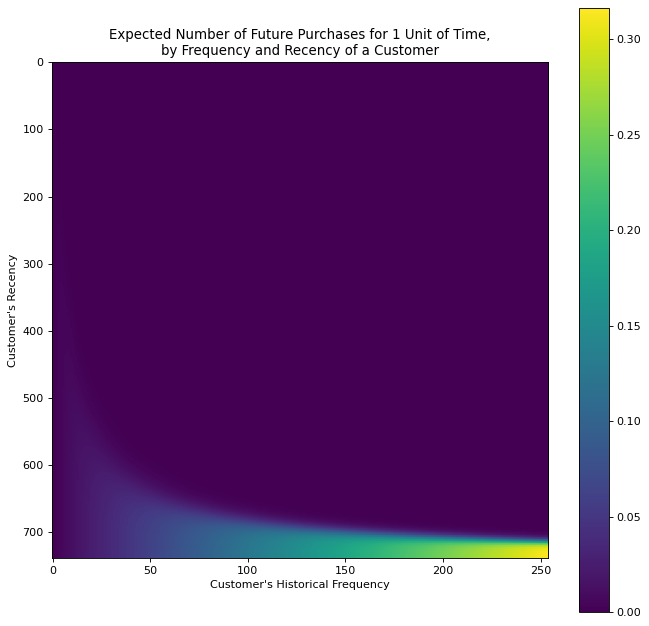

In [7]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plot_frequency_recency_matrix(bgf)

In [8]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt['pred_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt['Frequency'], 
                                                                                      df_rfmt['Recency'], 
                                                                                      df_rfmt['Age'])

In [9]:
df_rfmt.sort_values(by='pred_purchases_180').tail(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180
1432,13798,98,730,731,761.907778,4248.879906,22.078420
620,12971,98,721,724,158.632323,536.722457,22.264698
1788,14156,118,729,738,2569.799328,15328.797409,26.265102
2156,14527,120,735,737,225.180826,1419.270355,26.801500
737,13089,131,735,737,859.219015,12557.217592,29.246671
2235,14606,180,735,736,164.814199,961.447014,40.195852
5430,17841,192,736,737,355.156736,3469.396759,42.814170
2933,15311,195,738,738,586.563367,8402.806939,43.434158
399,12748,202,735,735,261.851034,2946.205464,45.156118
2537,14911,253,737,738,1134.041220,7328.269179,56.306828


In [10]:
df_rfmt.sort_values(by='pred_purchases_180').head(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180
486,12835,36,309,736,162.076486,337.447593,1.913494e-09
5045,17448,17,148,645,806.870556,1039.394681,3.945038e-07
741,13093,42,460,735,1259.168605,1760.342867,5.666458e-05
1696,14063,6,45,731,1353.071429,406.126978,1.750202e-04
2219,14590,18,308,732,157.545789,188.333075,4.991638e-04
4361,16754,18,269,641,3447.372105,3695.422153,6.852320e-04
5438,17850,22,362,734,2226.472609,3029.948212,7.098310e-04
3253,15633,12,222,731,333.535385,84.745002,8.185821e-04
1792,14160,6,88,698,1203.067143,436.245095,2.245069e-03
5637,18051,6,96,730,326.040000,95.141519,2.309174e-03


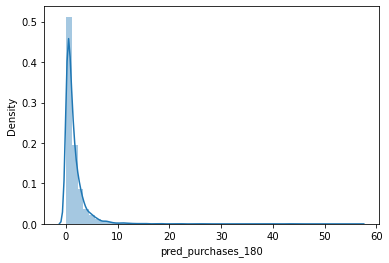

In [11]:
# visualize predicted purchases in 180 days
ax = sns.distplot(df_rfmt['pred_purchases_180'])

In [12]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt['Pred_purchases_lifetime'] = df_rfmt['pred_purchases_180']/180 * df_rfmt['Recency']
df_rfmt.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653
4,12350,0,0,310,0.000000,17.426721,0.314474,0.000000


In [13]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt)-1)/(len(df_rfmt)-4)
rmse = mean_squared_error(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'])

In [14]:
# print results
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.9609052425493319
Adjusted R-squared: 0.9608852622644337
Root Mean Squared Error: 1.975186757974788
Mean Squared Error: 3.9013627288789534
Mean Absolute Error: 0.9193568271525402


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

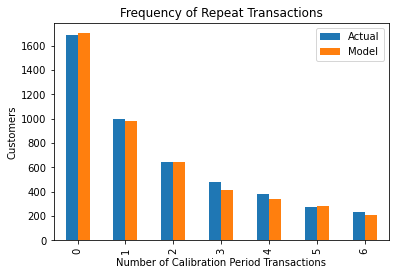

In [15]:
# check the overall model fit
plot_period_transactions(bgf)

In [ ]:
# Checking how this model correctly predicts the frequency of repeat purchases within the different calibration periods 
# The model slight over-estimates the number of one-time customers however this model is still a good fit for the dataset.

In [16]:
# compute the probability that a customer is still alive
df_rfmt['alive_prob'] = bgf.conditional_probability_alive(df_rfmt['Frequency'], df_rfmt['Recency'], df_rfmt['Age'])
df_rfmt.head(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219,0.039783
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094,0.986843
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099,0.959163
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653,0.967096
4,12350,0,0,310,0.000000,17.426721,0.314474,0.000000,1.000000
5,12351,0,0,375,0.000000,21.460923,0.268389,0.000000,1.000000
6,12352,8,356,392,285.537778,221.050184,3.287503,6.501951,0.976993
7,12353,1,204,408,203.380000,18.453778,0.561831,0.636742,0.897574
8,12354,0,0,232,0.000000,18.327934,0.396139,0.000000,1.000000
9,12355,1,353,567,473.805000,60.184559,0.431382,0.845988,0.918624


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

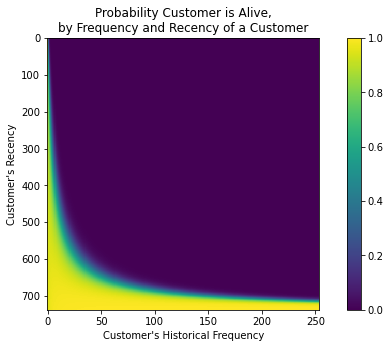

In [17]:
# visualize this
fig = plt.figure(figsize = (10,5))
plot_probability_alive_matrix(bgf)
# this illustrates that if the time between a customer's first and last purchases is high and the customer's frequency of
# purchases is also high, the customer is probably alive. Similarily, if a customer has low frequency but the time between
# the first and last purchases is also low, the customer is also probably alive. 

Using Holdout period

Re-fit the model using a calibration and holdout period.

In the first instance, the dataset contains data from 01/12/2009 to 09/12/2011 being 738 days. Use 60% of the data in the calibration set and 40% in the observation set. Hence calibration period will be 01/12/2009 - 17/02/2011, then observation period will be 18/02/2011 - 09/12/2011.

In [18]:
data = pd.read_csv('processed_data.csv')
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate)
data.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Date,Time,Total_Price,Year,Day_of_week,days_since,seconds,time_of_day
0,1,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01,07:45,83.4,2009,Tuesday,738,27900,6 AM - 12 PM
1,2,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
2,3,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
3,4,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12-01,07:45,100.8,2009,Tuesday,738,27900,6 AM - 12 PM
4,5,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01,07:45,30.0,2009,Tuesday,738,27900,6 AM - 12 PM


In [19]:
cal_hold = calibration_and_holdout_data(data, 'Customer_ID', 'InvoiceDate', calibration_period_end='2011-02-17',
                                                                                observation_period_end='2011-12-09')
cal_hold.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
12346,6.0,196.0,430.0,0.0,295.0
12347,2.0,87.0,109.0,5.0,295.0
12348,2.0,120.0,143.0,2.0,295.0
12349,1.0,182.0,294.0,1.0,295.0
12350,0.0,0.0,15.0,0.0,295.0


In [20]:
cal_hold.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
14911,140.0,430.0,443.0,113.0,295.0
12748,105.0,410.0,440.0,96.0,295.0
17841,97.0,438.0,442.0,95.0,295.0
14606,110.0,438.0,441.0,70.0,295.0
15311,129.0,441.0,443.0,65.0,295.0


In [21]:
# re-fit the model using the calibration set and observe its effect on the observation set
bgf.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 4473 subjects, a: 0.15, alpha: 69.71, b: 8.39, r: 0.75>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

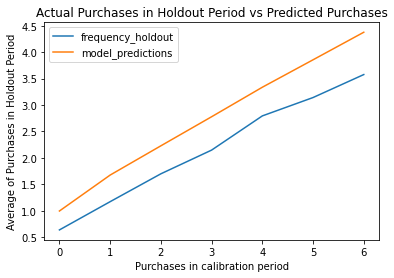

In [22]:
# visualize how the model fits within the observation period
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold)

Using a longer holdout 

In [23]:
cal_hold_long = calibration_and_holdout_data(data, 'Customer_ID', 'InvoiceDate', calibration_period_end='2011-06-01',
                                                                                observation_period_end='2011-12-09')

cal_hold_long.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
14911,168.0,541.0,547.0,85.0,191.0
12748,129.0,543.0,544.0,72.0,191.0
17841,124.0,545.0,546.0,68.0,191.0
15311,147.0,542.0,547.0,47.0,191.0
14606,136.0,542.0,545.0,44.0,191.0


In [24]:
# re-fit the model using the calibration set and observe its effect on the observation set
bgf.fit(cal_hold_long['frequency_cal'], cal_hold_long['recency_cal'], cal_hold_long['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 4930 subjects, a: 0.16, alpha: 66.05, b: 3.41, r: 0.68>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

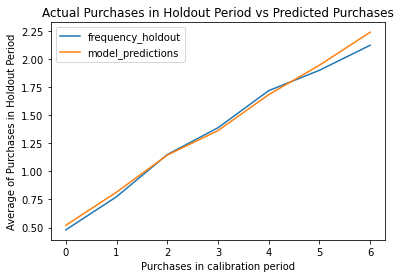

In [25]:
# visualize how the model fits within the observation period
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold_long)

In [26]:
# getting predictions for a particular customer
df_rfmt.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219,0.039783
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094,0.986843
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099,0.959163
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653,0.967096
4,12350,0,0,310,0.000000,17.426721,0.314474,0.000000,1.000000


In [27]:
df_rfmt.sort_values(by = 'Frequency').tail()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob
2235,14606,180,735,736,164.814199,961.447014,40.195852,164.133064,0.999247
5430,17841,192,736,737,355.156736,3469.396759,42.814170,175.062385,0.999283
2933,15311,195,738,738,586.563367,8402.806939,43.434158,178.080050,0.999445
399,12748,202,735,735,261.851034,2946.205464,45.156118,184.387480,0.999464
2537,14911,253,737,738,1134.041220,7328.269179,56.306828,230.545178,0.999412


In [28]:
# for customer in index 2235
t = 365
individual = df_rfmt.iloc[2235]
bgf.predict(t, individual['Frequency'], individual['Recency'], individual['Age'])

79.60575406923621

In [29]:
data.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Date,Time,Total_Price,Year,Day_of_week,days_since,seconds,time_of_day
0,1,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01,07:45,83.4,2009,Tuesday,738,27900,6 AM - 12 PM
1,2,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
2,3,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
3,4,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12-01,07:45,100.8,2009,Tuesday,738,27900,6 AM - 12 PM
4,5,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01,07:45,30.0,2009,Tuesday,738,27900,6 AM - 12 PM


In [30]:
cust_14606 = data.loc[data['Customer_ID'] == 14606]
cust_14606

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Date,Time,Total_Price,Year,Day_of_week,days_since,seconds,time_of_day
5222,5223,490024,84993B,75 BLACK PETIT FOUR CASES,5,2009-12-03 12:40:00,0.42,14606,United Kingdom,2009-12-03,12:40,2.10,2009,Thursday,736,45600,12 PM - 6 PM
5223,5224,490024,21944,KITTENS DESIGN FLANNEL,1,2009-12-03 12:40:00,0.85,14606,United Kingdom,2009-12-03,12:40,0.85,2009,Thursday,736,45600,12 PM - 6 PM
5224,5225,490024,20718,RED SPOTTY SHOPPER BAG,1,2009-12-03 12:40:00,1.25,14606,United Kingdom,2009-12-03,12:40,1.25,2009,Thursday,736,45600,12 PM - 6 PM
5225,5226,490024,20749,ASSORTED COLOUR MINI CASES,2,2009-12-03 12:40:00,7.95,14606,United Kingdom,2009-12-03,12:40,15.90,2009,Thursday,736,45600,12 PM - 6 PM
5226,5227,490024,21536,DAIRY MAID SMALL MILK JUG,1,2009-12-03 12:40:00,2.10,14606,United Kingdom,2009-12-03,12:40,2.10,2009,Thursday,736,45600,12 PM - 6 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776932,776933,581469,21485,RETROSPOT HEART HOT WATER BOTTLE,1,2011-12-08 19:28:00,4.95,14606,United Kingdom,2011-12-08,19:28,4.95,2011,Thursday,1,70080,6 PM - 0 AM
776933,776934,581469,22165,"DIAMANTE HEART SHAPED WALL MIRROR,",1,2011-12-08 19:28:00,3.95,14606,United Kingdom,2011-12-08,19:28,3.95,2011,Thursday,1,70080,6 PM - 0 AM
776934,776935,581469,21986,PACK OF 12 PINK POLKADOT TISSUES,1,2011-12-08 19:28:00,0.39,14606,United Kingdom,2011-12-08,19:28,0.39,2011,Thursday,1,70080,6 PM - 0 AM
776935,776936,581469,22087,PAPER BUNTING WHITE LACE,6,2011-12-08 19:28:00,2.95,14606,United Kingdom,2011-12-08,19:28,17.70,2011,Thursday,1,70080,6 PM - 0 AM


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

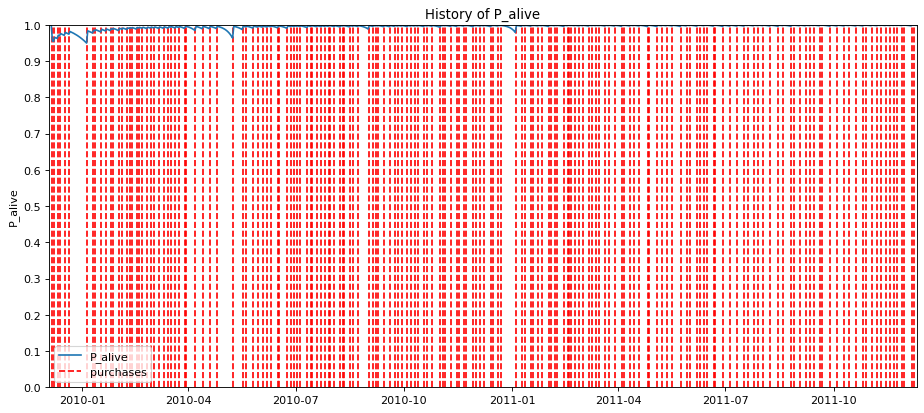

In [31]:
# plot the customer's probability of being alive
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 737
plot_history_alive(bgf, days_since_birth, cust_14606, 'InvoiceDate')

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

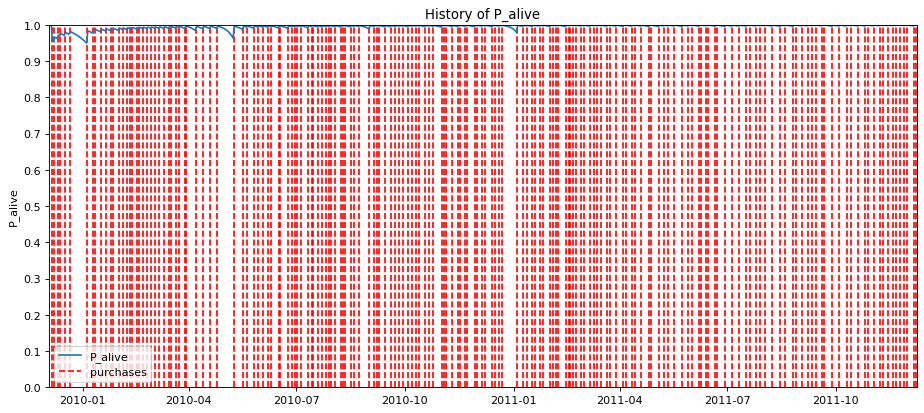

In [32]:
# decrease the tenure and observe the probability
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 182
plot_history_alive(bgf, days_since_birth, cust_14606, 'InvoiceDate')

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

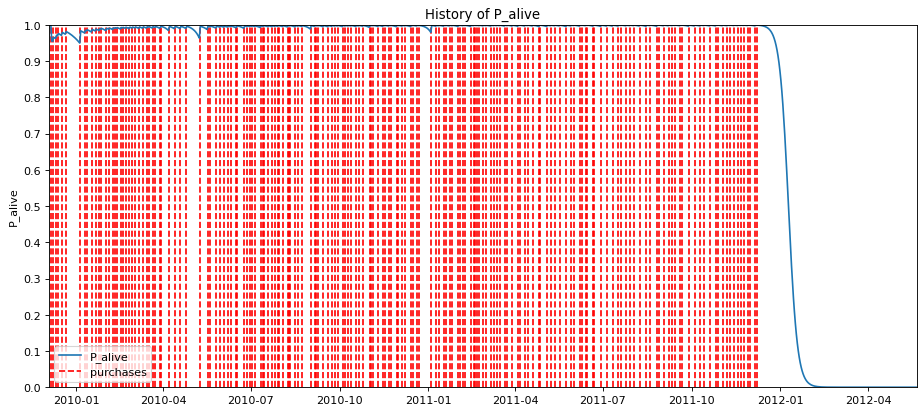

In [33]:
# increase the tenure and observe the probability
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 900
plot_history_alive(bgf, days_since_birth, cust_14606, 'InvoiceDate')

Gamma gamma model

In [34]:
# remove one-time customers: Frequency = 0
return_cust = df_rfmt.loc[(df_rfmt["Frequency"] > 0)]

In [35]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [36]:
# the correlation coefficient is very weak hence the assumption is satisfied

In [37]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust['Frequency'], return_cust['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


In [39]:
# remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt[df_rfmt['Avg_Amount'] > 0]

In [40]:
# predict clv
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob,pred_clv
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219,0.039783,0.719239
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094,0.986843,282.936001
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099,0.959163,89.331948
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653,0.967096,117.983502
6,12352,8,356,392,285.537778,221.050184,3.287503,6.501951,0.976993,160.332053


In [41]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [42]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7553723108614163
Adjusted R-squared: 0.7551966567045432
Root Mean Squared Error: 329.3916596096178
Mean Squared Error: 108498.86542037834
Mean Absolute Error: 89.88858814508859


Extended BG/NBD/GG with DPR

In [43]:
df_rfmt_full.head()

,Unnamed: 0,Customer_ID,Recency,Frequency,Count_of_transactions,Total_Amount,DPR,Age,Avg_Amount,CSI,months_inactive,CLV
0,1,12346,196,6,7,372.86,26,725,53.265714,1,0.204123,14.079332
1,2,12347,402,7,8,4921.53,126,404,615.191250,6,0.060640,287.393856
2,3,12348,363,4,5,1658.40,24,438,331.680000,5,0.268889,140.406568
3,4,12349,571,2,3,3678.69,137,589,1226.230000,5,0.111314,65.606970
4,5,12350,0,0,1,294.40,16,310,0.000000,2,0.000000,17.426721


In [44]:
# select the relevant columns
df_rfmt2 = df_rfmt_full[['Customer_ID', 'Frequency', 'Recency', 'Age', 'Avg_Amount', 'DPR', 'CSI', 'CLV']]
df_rfmt2.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV
0,12346,6,196,725,53.265714,26,1,14.079332
1,12347,7,402,404,615.191250,126,6,287.393856
2,12348,4,363,438,331.680000,24,5,140.406568
3,12349,2,571,589,1226.230000,137,5,65.606970
4,12350,0,0,310,0.000000,16,2,17.426721


In [45]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt2['Frequency'], df_rfmt2['Recency'], df_rfmt2['Age'], df_rfmt2['DPR'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.825374,0.001707,0.822028,0.828721
alpha,32.780414,0.086631,32.610617,32.950211
a,0.052045,0.000984,0.050116,0.053975
b,7.250060,0.214406,6.829824,7.670295


In [46]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt2['predicted_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt2['Frequency'], 
                                                                                      df_rfmt2['Recency'], 
                                                                                      df_rfmt2['Age'])

In [47]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt2['Pred_purchases_lifetime'] = df_rfmt2['predicted_purchases_180']/180 * df_rfmt2['Recency']
df_rfmt2.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,predicted_purchases_180,Pred_purchases_lifetime
0,12346,6,196,725,53.265714,26,1,14.079332,0.100501,0.109434
1,12347,7,402,404,615.191250,126,6,287.393856,3.192291,7.129449
2,12348,4,363,438,331.680000,24,5,140.406568,1.814835,3.659916
3,12349,2,571,589,1226.230000,137,5,65.606970,0.809948,2.569334
4,12350,0,0,310,0.000000,16,2,17.426721,0.432022,0.000000


In [48]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt2)-1)/(len(df_rfmt2)-4)
rmse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])

In [49]:
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.9738553190821315
Adjusted R-squared: 0.9738419572349843
Root Mean Squared Error: 1.6152530759516501
Mean Squared Error: 2.609042499371267
Mean Absolute Error: 0.6392040856697755


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

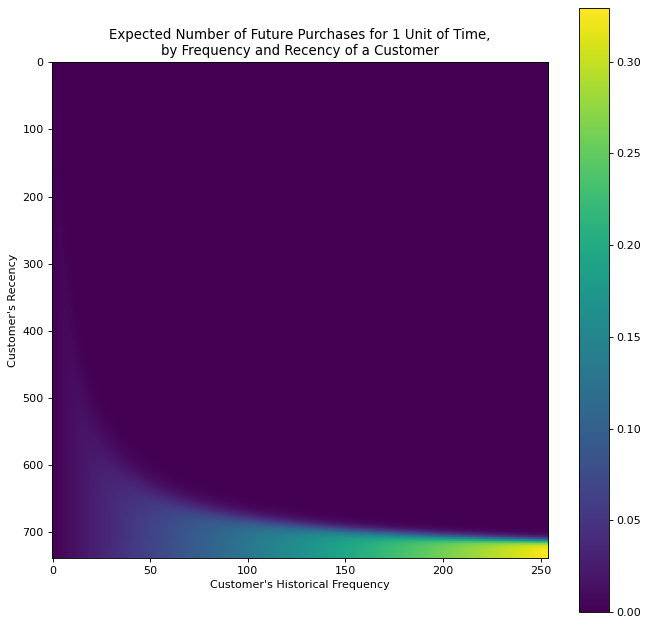

In [50]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plot_frequency_recency_matrix(bgf)

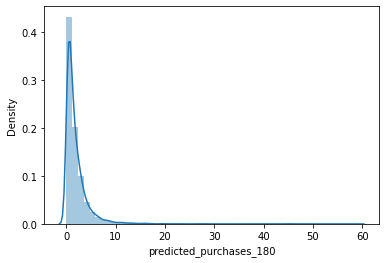

In [51]:
ax = sns.distplot(df_rfmt2['predicted_purchases_180'])

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

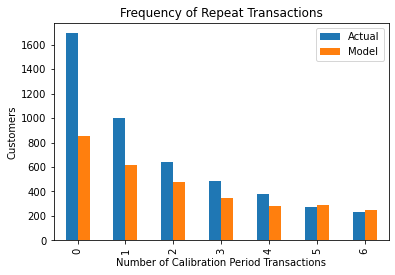

In [52]:
plot_period_transactions(bgf)

In [53]:
# compute the probability that a customer is still alive
df_rfmt2['alive_prob'] = bgf.conditional_probability_alive(df_rfmt2['Frequency'], df_rfmt2['Recency'], df_rfmt2['Age'])
df_rfmt2.head(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,predicted_purchases_180,Pred_purchases_lifetime,alive_prob
0,12346,6,196,725,53.265714,26,1,14.079332,0.100501,0.109434,0.062204
1,12347,7,402,404,615.191250,126,6,287.393856,3.192291,7.129449,0.995945
2,12348,4,363,438,331.680000,24,5,140.406568,1.814835,3.659916,0.988406
3,12349,2,571,589,1226.230000,137,5,65.606970,0.809948,2.569334,0.993192
4,12350,0,0,310,0.000000,16,2,17.426721,0.432022,0.000000,1.000000
5,12351,0,0,375,0.000000,21,3,21.460923,0.363336,0.000000,1.000000
6,12352,8,356,392,285.537778,69,3,221.050184,3.686128,7.290341,0.992083
7,12353,1,204,408,203.380000,23,4,18.453778,0.726653,0.823540,0.978169
8,12354,0,0,232,0.000000,58,5,18.327934,0.558792,0.000000,1.000000
9,12355,1,353,567,473.805000,35,4,60.184559,0.537776,1.054639,0.984189


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

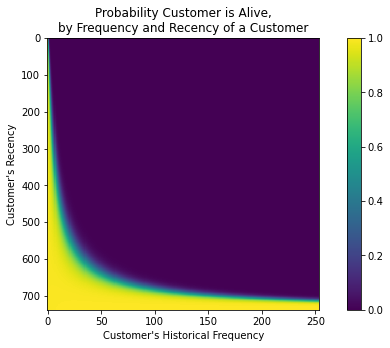

In [54]:
# visualize this
fig = plt.figure(figsize = (10,5))
plot_probability_alive_matrix(bgf)
# this illustrates that if the time between a customer's first and last purchases is high and the customer's frequency of
# purchases is also high, the customer is probably alive. Similarily, if a customer has low frequency but the time between
# the first and last purchases is also low, the customer is also probably alive. 

In [55]:
# gamma gamma model
# remove one-time customers: Frequency = 0
return_cust2 = df_rfmt2.loc[(df_rfmt2["Frequency"] > 0)]

In [56]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust2[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [57]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust2['Frequency'], return_cust2['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


In [58]:
# remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt2[df_rfmt2['Avg_Amount'] > 0]

In [59]:
# predict clv
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,predicted_purchases_180,Pred_purchases_lifetime,alive_prob,pred_clv
0,12346,6,196,725,53.265714,26,1,14.079332,0.100501,0.109434,0.062204,1.496647
1,12347,7,402,404,615.191250,126,6,287.393856,3.192291,7.129449,0.995945,315.381630
2,12348,4,363,438,331.680000,24,5,140.406568,1.814835,3.659916,0.988406,102.908582
3,12349,2,571,589,1226.230000,137,5,65.606970,0.809948,2.569334,0.993192,135.511766
6,12352,8,356,392,285.537778,69,3,221.050184,3.686128,7.290341,0.992083,180.399948


In [60]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [61]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7137371841187155
Adjusted R-squared: 0.7135316339876374
Root Mean Squared Error: 356.3216916120479
Mean Squared Error: 126965.14791327136
Mean Absolute Error: 98.67573733140588


Extended BG/NBD/GG with CSI

In [62]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt2['Frequency'], df_rfmt2['Recency'], df_rfmt2['Age'], df_rfmt2['CSI'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.774634,0.009543,0.755929,0.793339
alpha,70.574349,1.084568,68.448597,72.700101
a,0.096157,0.008582,0.079337,0.112977
b,3.325671,0.461666,2.420806,4.230535


In [63]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt2['pred_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_rfmt2['Frequency'], 
                                                        df_rfmt2['Recency'], df_rfmt2['Age'])

In [64]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt2['Pred_purchases_lifetime'] = df_rfmt2['pred_purchases_180']/180 * df_rfmt2['Recency']
df_rfmt2.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,predicted_purchases_180,Pred_purchases_lifetime,alive_prob,pred_purchases_180
0,12346,6,196,725,53.265714,26,1,14.079332,0.100501,0.082600,0.062204,0.075857
1,12347,7,402,404,615.191250,126,6,287.393856,3.192291,6.426382,0.995945,2.877485
2,12348,4,363,438,331.680000,24,5,140.406568,1.814835,3.260731,0.988406,1.616892
3,12349,2,571,589,1226.230000,137,5,65.606970,0.809948,2.325729,0.993192,0.733154
4,12350,0,0,310,0.000000,16,2,17.426721,0.432022,0.000000,1.000000,0.362459


In [65]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt2)-1)/(len(df_rfmt2)-4)
rmse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])

In [66]:
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.961139229019821
Adjusted R-squared: 0.9611193683191497
Root Mean Squared Error: 1.9692670309366496
Mean Squared Error: 3.878012639134047
Mean Absolute Error: 0.8994367155758457


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

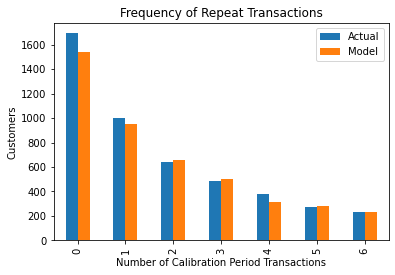

In [67]:
plot_period_transactions(bgf)

In [68]:
# gamma gamma model
# remove one-time customers: Frequency = 0
return_cust2 = df_rfmt2.loc[(df_rfmt2["Frequency"] > 0)]

In [69]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust2[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [70]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust2['Frequency'], return_cust2['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


In [71]:
# remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt2[df_rfmt2['Avg_Amount'] > 0]

In [72]:
# predict clv
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,predicted_purchases_180,Pred_purchases_lifetime,alive_prob,pred_purchases_180,pred_clv
0,12346,6,196,725,53.265714,26,1,14.079332,0.100501,0.082600,0.062204,0.075857,1.134293
1,12347,7,402,404,615.191250,126,6,287.393856,3.192291,6.426382,0.995945,2.877485,286.096461
2,12348,4,363,438,331.680000,24,5,140.406568,1.814835,3.260731,0.988406,1.616892,92.235258
3,12349,2,571,589,1226.230000,137,5,65.606970,0.809948,2.325729,0.993192,0.733154,123.229387
6,12352,8,356,392,285.537778,69,3,221.050184,3.686128,6.532406,0.992083,3.302902,162.696310


In [73]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [74]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7574553329805404
Adjusted R-squared: 0.7572811745312684
Root Mean Squared Error: 327.9862647853788
Mean Squared Error: 107574.9898878646
Mean Absolute Error: 89.57720620480477


BG/NBD/GG model with DPR and CSI

Using PCA to combine DPR and CSI to get a single component

In [75]:
# apply PCA first before applying BG/NBD/GG model with a combination of CSI and DPR

In [76]:
df_rfmt_full.head()

,Unnamed: 0,Customer_ID,Recency,Frequency,Count_of_transactions,Total_Amount,DPR,Age,Avg_Amount,CSI,months_inactive,CLV
0,1,12346,196,6,7,372.86,26,725,53.265714,1,0.204123,14.079332
1,2,12347,402,7,8,4921.53,126,404,615.191250,6,0.060640,287.393856
2,3,12348,363,4,5,1658.40,24,438,331.680000,5,0.268889,140.406568
3,4,12349,571,2,3,3678.69,137,589,1226.230000,5,0.111314,65.606970
4,5,12350,0,0,1,294.40,16,310,0.000000,2,0.000000,17.426721


In [77]:
# extract only the relevant colums and seperate the identifier column from the 2 features
pca_data = df_rfmt_full[['DPR', 'CSI']]
pca_data.head()

,DPR,CSI
0,26,1
1,126,6
2,24,5
3,137,5
4,16,2


In [78]:
df_rfmt4 = df_rfmt_full[['Customer_ID', 'Frequency', 'Recency', 'Age', 'Avg_Amount', 'DPR', 'CSI', 'CLV']]
df_rfmt4.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV
0,12346,6,196,725,53.265714,26,1,14.079332
1,12347,7,402,404,615.191250,126,6,287.393856
2,12348,4,363,438,331.680000,24,5,140.406568
3,12349,2,571,589,1226.230000,137,5,65.606970
4,12350,0,0,310,0.000000,16,2,17.426721


In [79]:
# standardize the dataset
scaler = StandardScaler()
pca_data = scaler.fit_transform(pca_data)

In [80]:
# fit the pca model
pca = PCA(n_components=1)
pc = pca.fit_transform(pca_data)

In [81]:
pc

array([[-1.76529174],
       [ 1.68501078],
       [ 0.49722486],
       ...,
       [-0.14427707],
       [ 0.75822721],
       [ 1.07992779]])

In [82]:
# add the components to a dataframe and combine with Customer_ID
pc_df = pd.DataFrame(data=pc, columns=['PC1'])
df_rfmt4 = pd.concat([df_rfmt4, pc_df], axis=1)

In [83]:
df_rfmt4.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1
0,12346,6,196,725,53.265714,26,1,14.079332,-1.765292
1,12347,7,402,404,615.191250,126,6,287.393856,1.685011
2,12348,4,363,438,331.680000,24,5,140.406568,0.497225
3,12349,2,571,589,1226.230000,137,5,65.606970,1.183115
4,12350,0,0,310,0.000000,16,2,17.426721,-1.257326


In [84]:
df_rfmt4 = df_rfmt4.dropna()

In [85]:
df_rfmt4.describe()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1
count,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000
mean,15318.368942,4.717388,278.907938,475.575473,294.438119,83.620809,3.529616,140.153492,0.022958
std,1715.992383,10.069505,258.579085,223.256319,504.739944,117.104306,1.237460,573.238788,1.128953
min,12346.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-125.101976,-1.917037
25%,13834.000000,0.000000,0.000000,316.000000,0.000000,20.000000,3.000000,14.895303,-0.725081
50%,15321.000000,2.000000,231.000000,534.000000,227.636667,46.000000,4.000000,38.822903,-0.035020
75%,16802.000000,5.000000,518.000000,668.000000,381.665000,105.000000,5.000000,108.021326,0.661110
max,18287.000000,253.000000,738.000000,738.000000,22267.150000,2550.000000,6.000000,19492.287829,15.829596


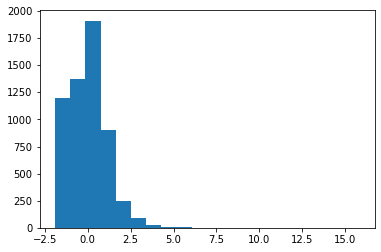

In [86]:
# Step 1: Check the distribution of PC1
plt.hist(df_rfmt4['PC1'], bins=20)
plt.show()

In [87]:
df_rfmt4['PC2'] = abs(df_rfmt4['PC1'])

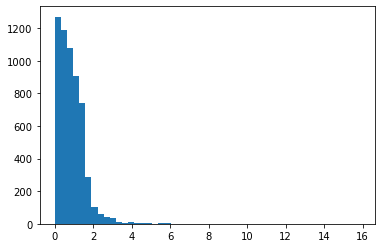

In [88]:
# Step 1: Check the distribution of PC1
plt.hist(df_rfmt4['PC2'], bins=50)
plt.show()

In [89]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt4['Frequency'], df_rfmt4['Recency'], df_rfmt4['Age'], df_rfmt4['PC2'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.451872,0.010489,0.431314,0.472429
alpha,26.875875,0.872666,25.165449,28.586301
a,0.042528,0.005634,0.031486,0.053569
b,1.031721,0.216520,0.607341,1.456101


In [90]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt4['pred_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt4['Frequency'], 
                                                                                      df_rfmt4['Recency'], 
                                                                                      df_rfmt4['Age'])

In [91]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt4['Pred_purchases_lifetime'] = df_rfmt4['pred_purchases_180']/180 * df_rfmt4['Recency']
df_rfmt4.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1,PC2,pred_purchases_180,Pred_purchases_lifetime
0,12346,6,196,725,53.265714,26,1,14.079332,-1.765292,1.765292,0.080877,0.088066
1,12347,7,402,404,615.191250,126,6,287.393856,1.685011,1.685011,3.068494,6.852970
2,12348,4,363,438,331.680000,24,5,140.406568,0.497225,0.497225,1.671736,3.371335
3,12349,2,571,589,1226.230000,137,5,65.606970,1.183115,1.183115,0.696403,2.209145
4,12350,0,0,310,0.000000,16,2,17.426721,-1.257326,1.257326,0.238366,0.000000


In [92]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt4)-1)/(len(df_rfmt4)-4)
rmse = mean_squared_error(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'])

In [93]:
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.9723056556648485
Adjusted R-squared: 0.9722912139765111
Root Mean Squared Error: 1.6755829454559832
Mean Squared Error: 2.807578207102948
Mean Absolute Error: 0.7161846743666683


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

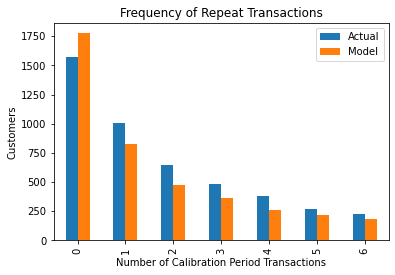

In [94]:
plot_period_transactions(bgf)

In [95]:
# gamma gamma model
# remove one-time customers: Frequency = 0
return_cust2 = df_rfmt4.loc[(df_rfmt4["Frequency"] > 0)]

In [96]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust2[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [97]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust2['Frequency'], return_cust2['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


In [98]:
# remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt4[df_rfmt4['Avg_Amount'] > 0]

In [99]:
# predict clv
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1,PC2,pred_purchases_180,Pred_purchases_lifetime,pred_clv
0,12346,6,196,725,53.265714,26,1,14.079332,-1.765292,1.765292,0.080877,0.088066,1.205878
1,12347,7,402,404,615.191250,126,6,287.393856,1.685011,1.685011,3.068494,6.852970,303.652127
2,12348,4,363,438,331.680000,24,5,140.406568,0.497225,0.497225,1.671736,3.371335,95.025038
3,12349,2,571,589,1226.230000,137,5,65.606970,1.183115,1.183115,0.696403,2.209145,116.833555
6,12352,8,356,392,285.537778,69,3,221.050184,-0.366961,0.366961,3.561473,7.043803,174.554978


In [100]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [101]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7126666368000109
Adjusted R-squared: 0.7124603179657361
Root Mean Squared Error: 356.98734435583816
Mean Squared Error: 127439.96403023376
Mean Absolute Error: 95.79146763447046
